In [179]:
import pandas as pd
import numpy as np
import scipy.stats as sci
from numpy import genfromtxt
from scipy.io.arff import loadarff
import scipy.stats

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.regression import setup, compare_models 

from sklearn.linear_model import BayesianRidge, HuberRegressor, Ridge, OrthogonalMatchingPursuit
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import optuna

#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', 90)



In [180]:
file1 = 'file1.arff'
raw_data = loadarff(file1)
df_data = pd.DataFrame(raw_data[0])

In [181]:
## Here we will check the percentage of nan values present in each feature
## 1 -step make the list of features which has missing values
features_with_na=[features for features in df_data.columns if df_data[features].isnull().sum()>1]
## 2- step print the feature name and the percentage of missing values

for feature in features_with_na:
    print(feature, np.round(df_data[feature].isnull().mean(), 4),  ' % missing values')
    print(feature)


In [182]:
for feature in features_with_na:
    data = df_data.copy()
    
    # let's make a variable that indicates 1 if the observation was missing or zero otherwise
    data[feature] = np.where(data[feature].isnull(), 1, 0)
    
    # let's calculate the mean SalePrice where the information is missing or present
    data.groupby(feature)['SalePrice'].median().plot.bar()
    plt.title(feature)
    plt.show()

In [183]:
target = df_data["Sale_Price"]
df_data = df_data.drop(['Sale_Price'],axis=1)

In [184]:
target

0       215000.0
1       105000.0
2       172000.0
3       244000.0
4       189900.0
          ...   
2925    142500.0
2926    131000.0
2927    132000.0
2928    170000.0
2929    188000.0
Name: Sale_Price, Length: 2930, dtype: float64

In [185]:
data1 = df_data.copy()

# Feature Engineering

In [186]:
data1["SqrFtPerRoom"] = data1["Gr_Liv_Area"]/(data1['TotRms_AbvGrd']+
                                              data1['Full_Bath']+
                                              data1['Half_Bath']+
                                              data1['Kitchen_AbvGr'])

data1["Total_Effective_SF"] = (0.5*data1["Total_Bsmt_SF"]+
                                data1["First_Flr_SF"]+
                                data1["Second_Flr_SF"])
        
data1['Total_Bathrooms'] = (data1['Full_Bath']+
                            0.5*data1['Half_Bath']+
                            0.5*data1['Bsmt_Half_Bath']+
                            data1['Bsmt_Full_Bath'])


In [187]:
data1['Mo_Sold'] = (-np.cos(0.5236 * data1["Mo_Sold"]))

In [188]:
dfnum = data1.copy()

# Feature Transformation

# Scewed Features

In [319]:
# list of numerical variables
numerical_features = [feature for feature in df_data.columns if df_data[feature].dtypes != 'O']

print('Number of numerical variables: ', len(numerical_features))

# visualise the numerical variables
dfnum[numerical_features].columns

Number of numerical variables:  34


Index(['Lot_Frontage', 'Lot_Area', 'Year_Built', 'Year_Remod_Add',
       'Mas_Vnr_Area', 'BsmtFin_SF_1', 'BsmtFin_SF_2', 'Bsmt_Unf_SF',
       'Total_Bsmt_SF', 'First_Flr_SF', 'Second_Flr_SF', 'Low_Qual_Fin_SF',
       'Gr_Liv_Area', 'Bsmt_Full_Bath', 'Bsmt_Half_Bath', 'Full_Bath',
       'Half_Bath', 'Bedroom_AbvGr', 'Kitchen_AbvGr', 'TotRms_AbvGrd',
       'Fireplaces', 'Garage_Cars', 'Garage_Area', 'Wood_Deck_SF',
       'Open_Porch_SF', 'Enclosed_Porch', 'Three_season_porch', 'Screen_Porch',
       'Pool_Area', 'Misc_Val', 'Mo_Sold', 'Year_Sold', 'Longitude',
       'Latitude'],
      dtype='object')

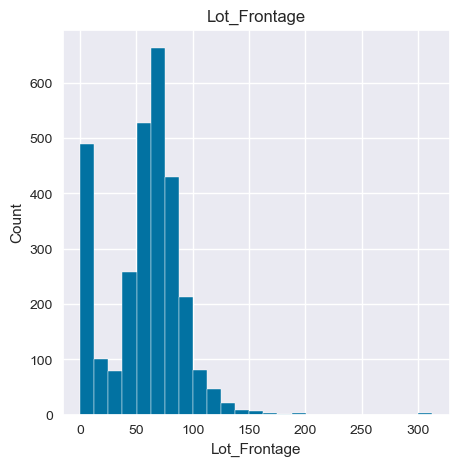

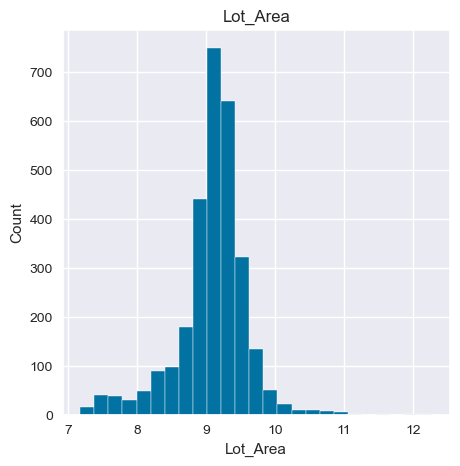

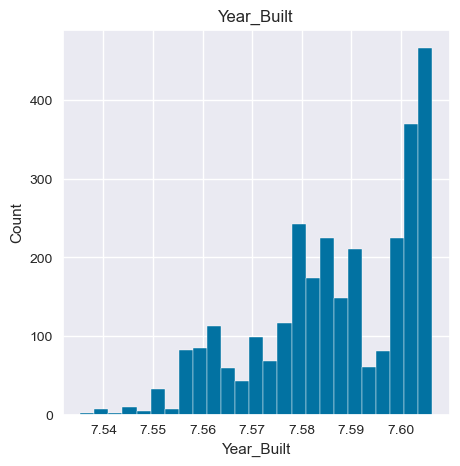

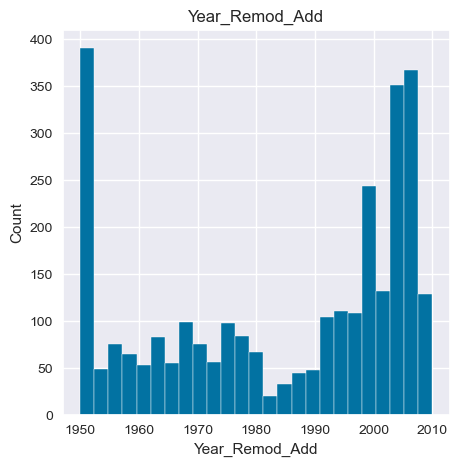

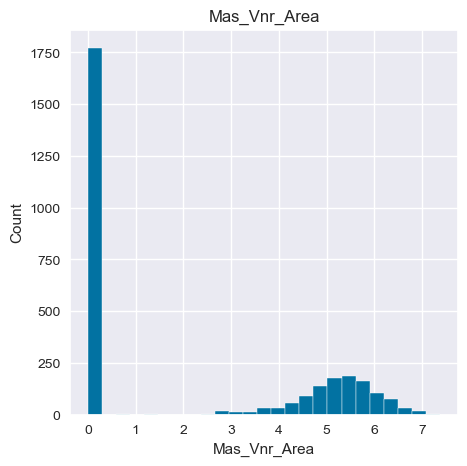

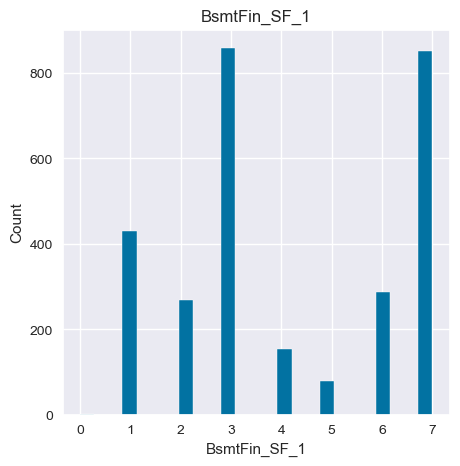

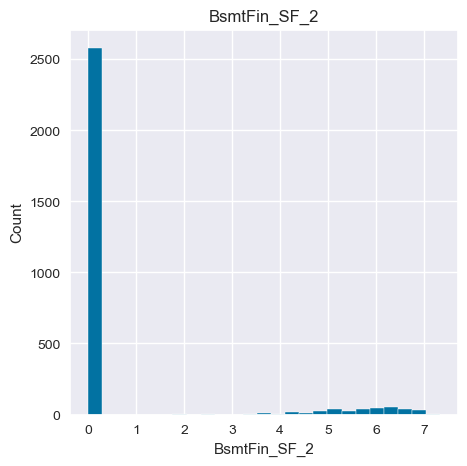

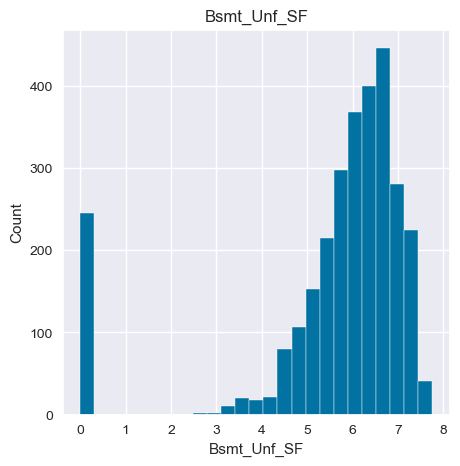

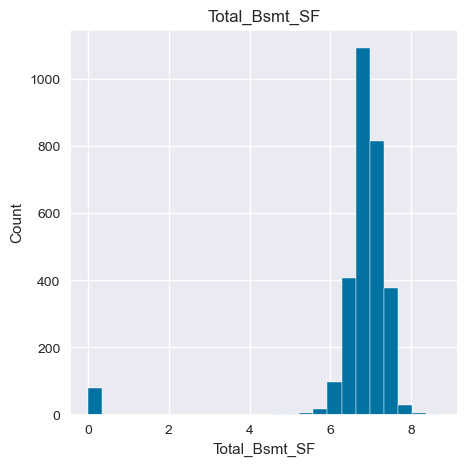

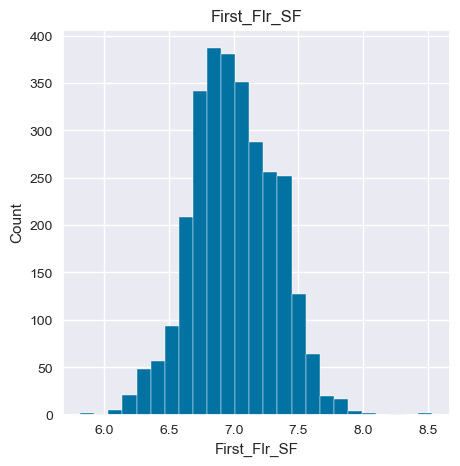

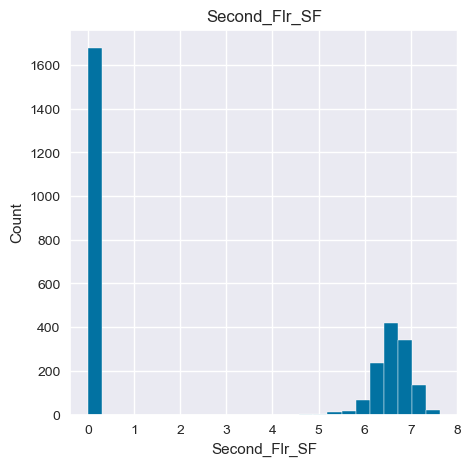

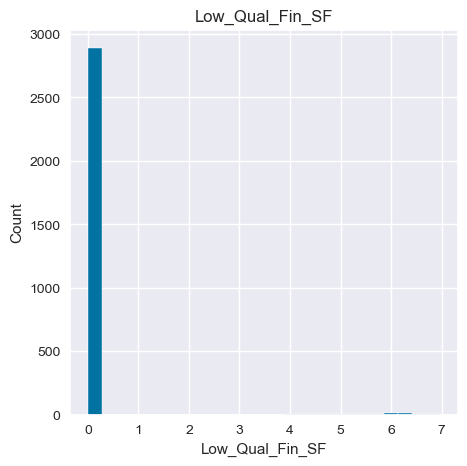

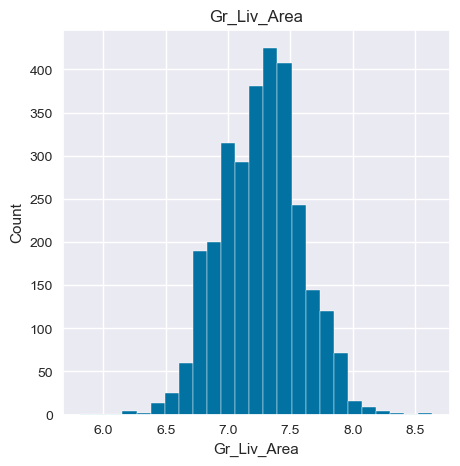

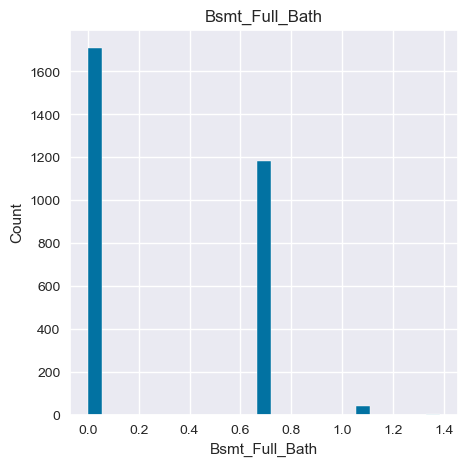

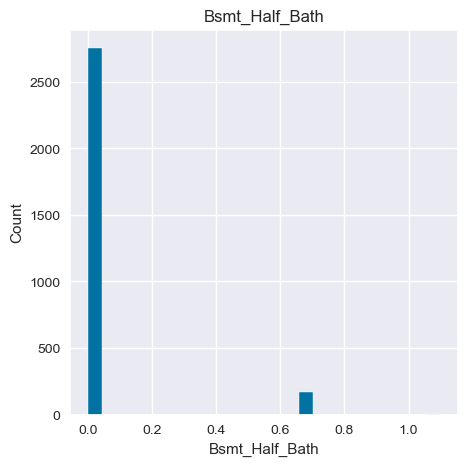

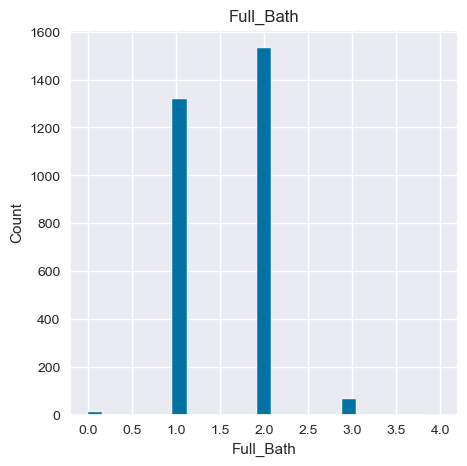

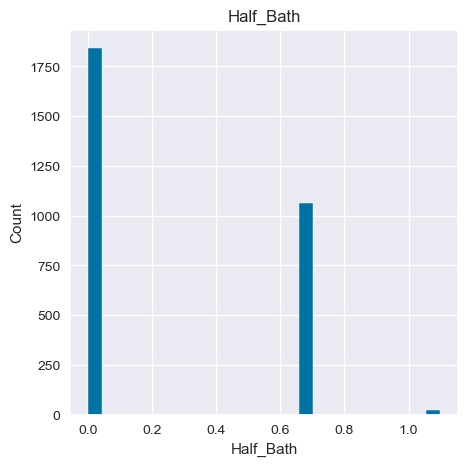

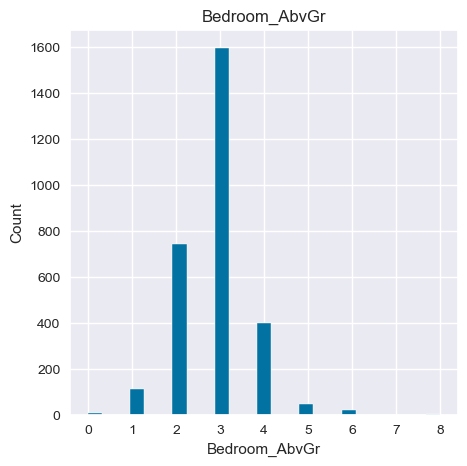

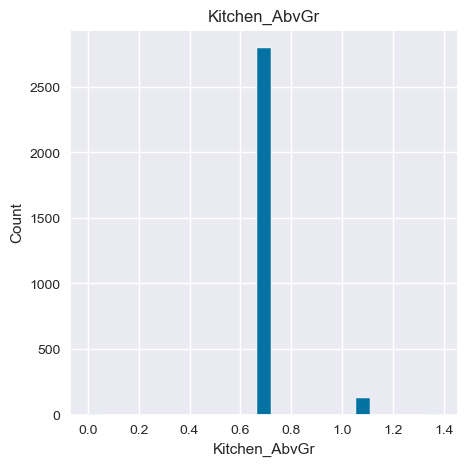

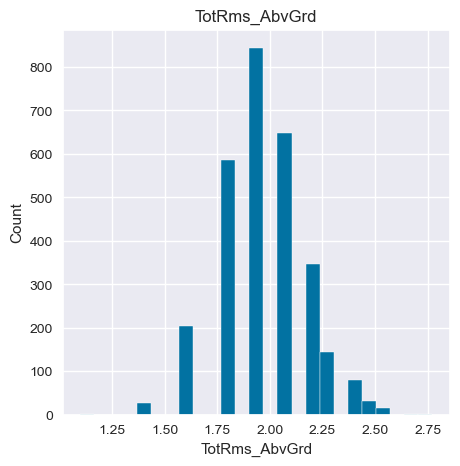

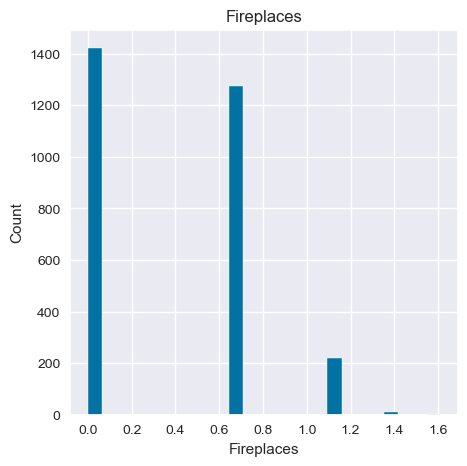

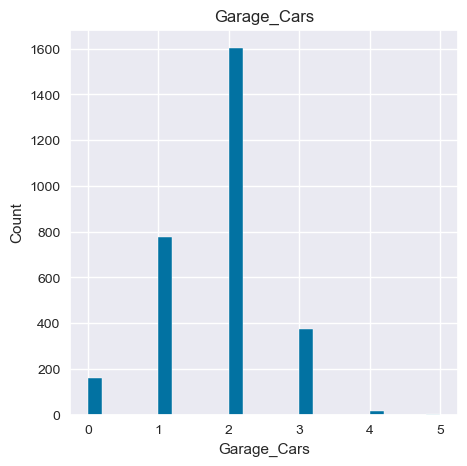

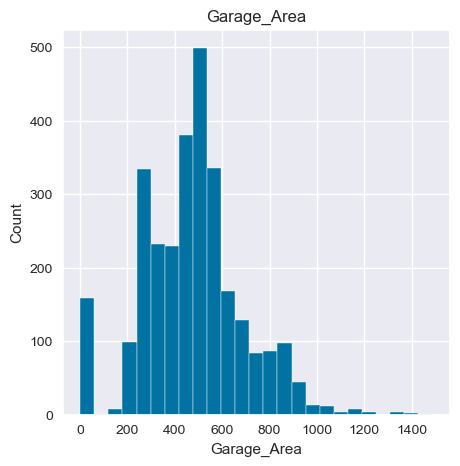

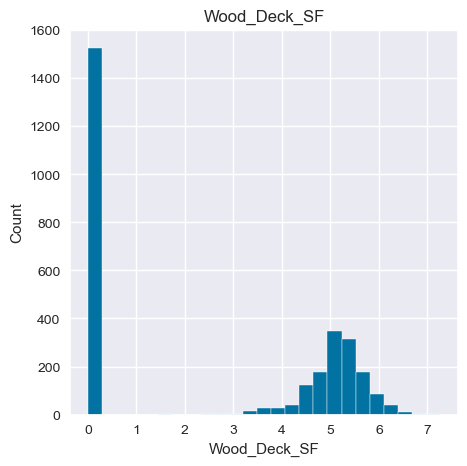

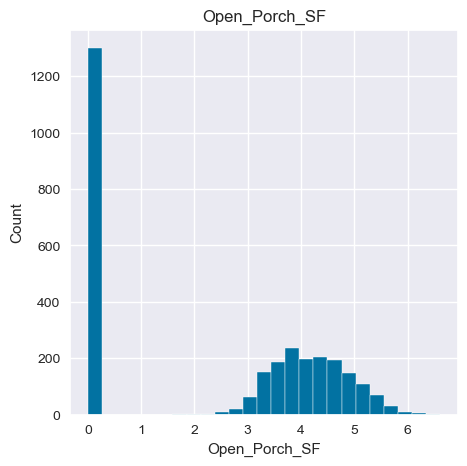

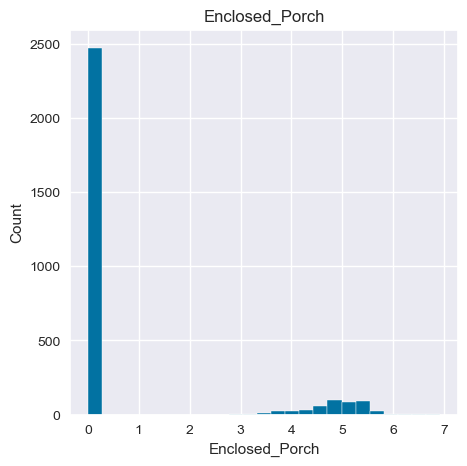

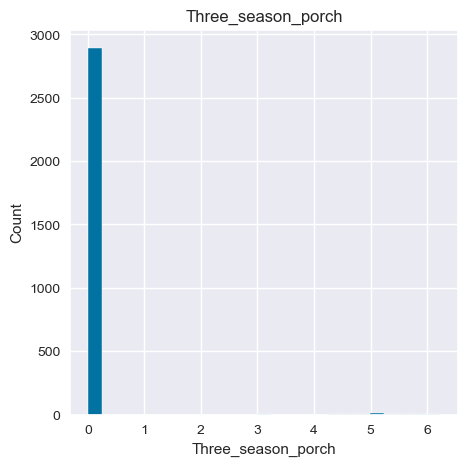

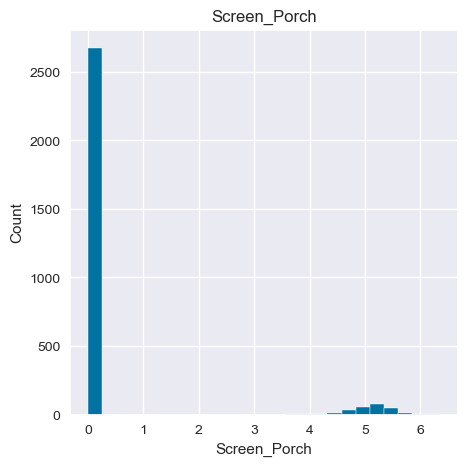

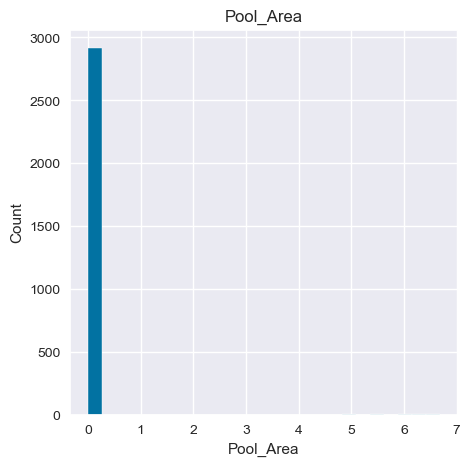

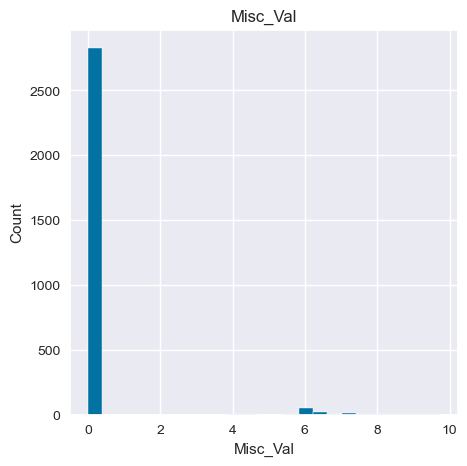

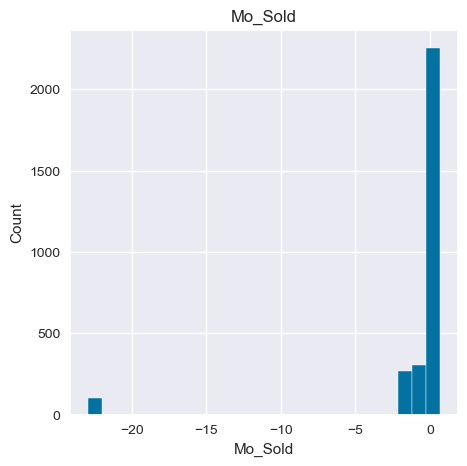

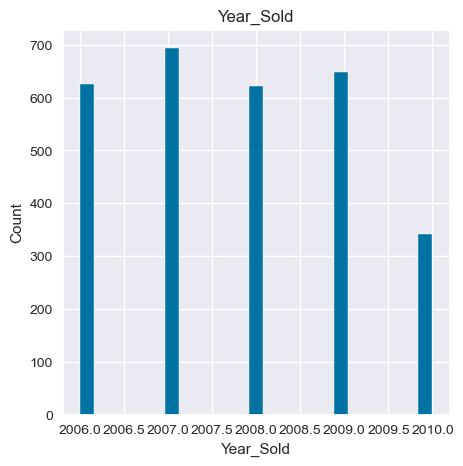

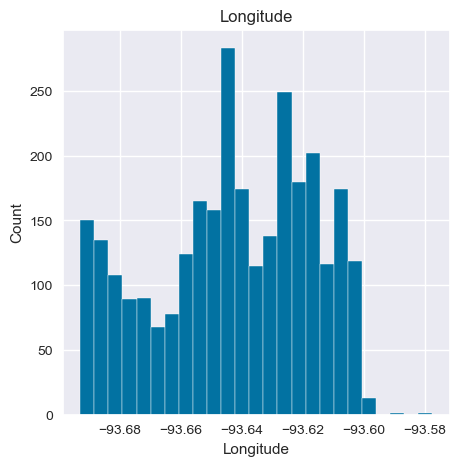

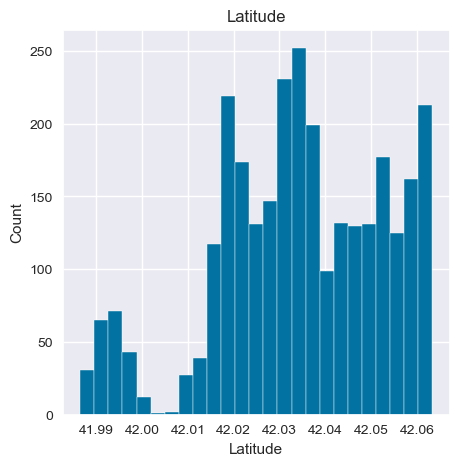

In [321]:
## Lets analyse the continuous values by creating histograms to understand the distribution

for feature in numerical_features:
    plt.figure(figsize=(5,5))
    dfnum[feature].hist(bins=25)
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.show()

In [190]:
sci.skew(dfnum[numerical_features])

array([ 0.02505136, 12.81433364, -0.60415273, -0.45163129,  2.617964  ,
        0.0891101 ,  4.13867358,  0.92257236,  1.1502567 ,  1.46867627,
        0.86601311, 12.11195684,  1.27345735,  0.61741142,  3.94037068,
        0.17186403,  0.69735582,  0.30553769,  4.31161584,  0.75315673,
        0.73883671, -0.22104928,  0.23994167,  1.84173461,  2.53408776,
        4.01239021, 11.39795591,  3.95544103, 16.93046935, 21.98852332,
       -0.75465578,  0.13479343, -0.30866772, -0.48664406])

In [191]:
dfnumskew = pd.DataFrame(dfnum.select_dtypes(np.number).columns, columns=["Feature"])
dfnumskew['Skew'] = dfnumskew["Feature"].apply(lambda feature : sci.skew(dfnum[feature]))
dfnumskew['Absolute_Skew'] = dfnumskew['Skew'].abs()
dfnumskew['Skewed'] = dfnumskew['Absolute_Skew'].apply(lambda x : True if  x >= 0.5 else False)

In [192]:
skewed_features = dfnumskew.query("Skewed == True")["Feature"].values
dfnum[skewed_features]

,Lot_Area,Year_Built,Mas_Vnr_Area,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF,First_Flr_SF,Second_Flr_SF,Low_Qual_Fin_SF,Gr_Liv_Area,...,Wood_Deck_SF,Open_Porch_SF,Enclosed_Porch,Three_season_porch,Screen_Porch,Pool_Area,Misc_Val,Mo_Sold,SqrFtPerRoom,Total_Effective_SF
0,31770.0,1960.0,112.0,0.0,441.0,1080.0,1656.0,0.0,0.0,1656.0,...,210.0,62.0,0.0,0.0,0.0,0.0,0.0,0.866028,184.000000,2196.0
1,11622.0,1961.0,0.0,144.0,270.0,882.0,896.0,0.0,0.0,896.0,...,140.0,0.0,0.0,0.0,120.0,0.0,0.0,1.000000,128.000000,1337.0
2,14267.0,1958.0,108.0,0.0,406.0,1329.0,1329.0,0.0,0.0,1329.0,...,393.0,36.0,0.0,0.0,0.0,0.0,12500.0,1.000000,147.666667,1993.5
3,11160.0,1968.0,0.0,0.0,1045.0,2110.0,2110.0,0.0,0.0,2110.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500004,175.833333,3165.0
4,13830.0,1997.0,0.0,0.0,137.0,928.0,928.0,701.0,0.0,1629.0,...,212.0,34.0,0.0,0.0,0.0,0.0,0.0,0.000004,162.900000,2093.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,7937.0,1984.0,0.0,0.0,184.0,1003.0,1003.0,0.0,0.0,1003.0,...,120.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000004,125.375000,1504.5
2926,8885.0,1983.0,0.0,324.0,239.0,864.0,902.0,0.0,0.0,902.0,...,164.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,128.857143,1334.0
2927,10441.0,1992.0,0.0,0.0,575.0,912.0,970.0,0.0,0.0,970.0,...,80.0,32.0,0.0,0.0,0.0,0.0,700.0,0.866021,121.250000,1426.0
2928,10010.0,1974.0,0.0,123.0,195.0,1389.0,1389.0,0.0,0.0,1389.0,...,240.0,38.0,0.0,0.0,0.0,0.0,0.0,0.500004,173.625000,2083.5


In [193]:
dfnumskew

,Feature,Skew,Absolute_Skew,Skewed
0,Lot_Frontage,0.025051,0.025051,False
1,Lot_Area,12.814334,12.814334,True
2,Year_Built,-0.604153,0.604153,True
3,Year_Remod_Add,-0.451631,0.451631,False
4,Mas_Vnr_Area,2.617964,2.617964,True
5,BsmtFin_SF_1,0.089110,0.089110,False
6,BsmtFin_SF_2,4.138674,4.138674,True
7,Bsmt_Unf_SF,0.922572,0.922572,True
8,Total_Bsmt_SF,1.150257,1.150257,True
9,First_Flr_SF,1.468676,1.468676,True


In [194]:
for column in skewed_features:
    dfnum[column] = np.log1p(dfnum[column])

# Encode Categorical Features

In [195]:
dfnum2 = dfnum.copy()

In [196]:
dfnum2 = pd.get_dummies(dfnum2)

# Scaling

In [197]:
scaler = StandardScaler()
scaler.fit(dfnum2)
dfnum2 = pd.DataFrame(scaler.transform(dfnum2), index=dfnum2.index, columns=dfnum2.columns)
dfnum2

,Lot_Frontage,Lot_Area,Year_Built,Year_Remod_Add,Mas_Vnr_Area,BsmtFin_SF_1,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF,First_Flr_SF,...,Sale_Type_b'New',Sale_Type_b'Oth',Sale_Type_b'VWD',Sale_Type_b'WD ',Sale_Condition_b'Abnorml',Sale_Condition_b'AdjLand',Sale_Condition_b'Alloca',Sale_Condition_b'Family',Sale_Condition_b'Normal',Sale_Condition_b'Partial'
0,2.488592,2.493250,-0.367121,-1.163488,1.013354,-0.975138,-0.364142,0.252382,0.215921,1.267350,...,-0.298018,-0.048937,-0.018477,0.394161,-0.263331,-0.064128,-0.090878,-0.126294,0.462878,-0.302072
1,0.667355,0.525278,-0.334030,-1.115542,-0.791606,0.816181,2.279281,-0.008546,0.045442,-0.636658,...,-0.298018,-0.048937,-0.018477,0.394161,-0.263331,-0.064128,-0.090878,-0.126294,0.462878,-0.302072
2,0.697212,0.926544,-0.433353,-1.259380,0.999594,-1.422968,-0.364142,0.208380,0.390593,0.585336,...,-0.298018,-0.048937,-0.018477,0.394161,-0.263331,-0.064128,-0.090878,-0.126294,0.462878,-0.302072
3,1.055488,0.445898,-0.102867,-0.779919,-0.791606,-1.422968,-0.364142,0.711853,0.779876,2.018621,...,-0.298018,-0.048937,-0.018477,0.394161,-0.263331,-0.064128,-0.090878,-0.126294,0.462878,-0.302072
4,0.488217,0.865665,0.846134,0.658466,-0.791606,-0.527308,-0.364142,-0.368512,0.088234,-0.527907,...,-0.298018,-0.048937,-0.018477,0.394161,-0.263331,-0.064128,-0.090878,-0.126294,0.462878,-0.302072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,-0.616467,-0.221003,0.422435,-0.012780,-0.791606,-0.527308,-0.364142,-0.212175,0.153655,-0.287036,...,-0.298018,-0.048937,-0.018477,0.394161,-0.263331,-0.064128,-0.090878,-0.126294,0.462878,-0.302072
2926,-1.721152,-0.000214,0.389728,-0.060726,-0.791606,-0.975138,2.707973,-0.073342,0.028087,-0.615974,...,-0.298018,-0.048937,-0.018477,0.394161,-0.263331,-0.064128,-0.090878,-0.126294,0.462878,-0.302072
2927,0.129941,0.315578,0.683500,0.370789,-0.791606,-0.527308,-0.364142,0.393623,0.073595,-0.390723,...,-0.298018,-0.048937,-0.018477,0.394161,-0.263331,-0.064128,-0.090878,-0.126294,0.462878,-0.302072
2928,0.577786,0.233084,0.094620,-0.444296,-0.791606,-1.422968,2.196181,-0.181367,0.427774,0.722232,...,-0.298018,-0.048937,-0.018477,0.394161,-0.263331,-0.064128,-0.090878,-0.126294,0.462878,-0.302072


# Target Transformation

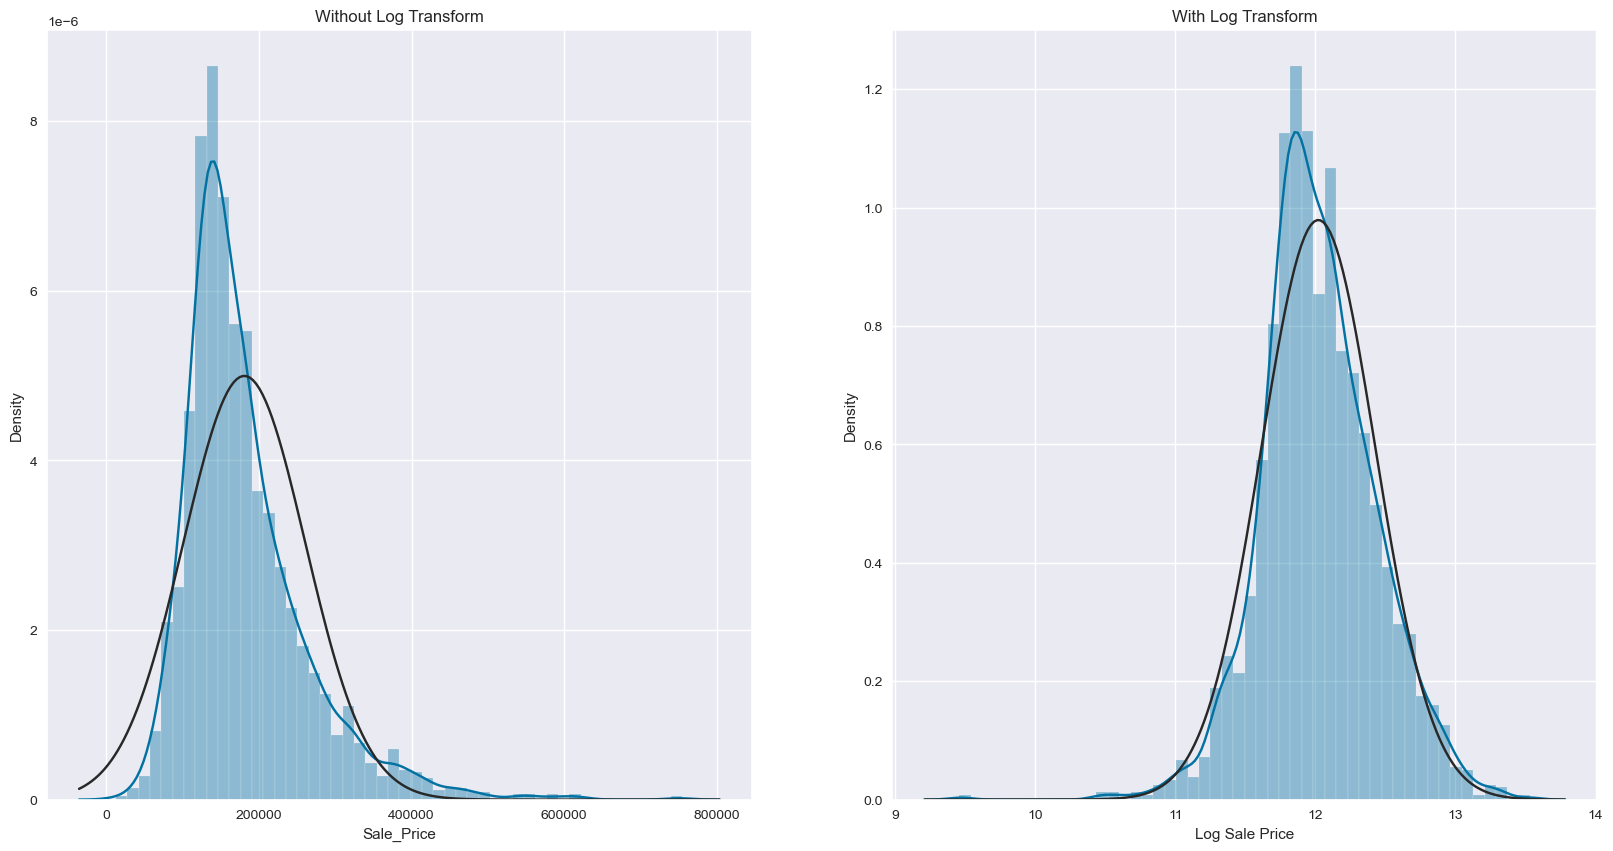

In [198]:
sns.set_style("darkgrid")
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
sns.distplot(target, kde=True, fit=scipy.stats.norm)
plt.title("Without Log Transform")


plt.subplot(1,2,2)
sns.distplot(np.log(target), kde=True, fit=scipy.stats.norm)
plt.xlabel("Log Sale Price")
plt.title("With Log Transform")

plt.show()

In [199]:
log_target = np.log(target)

# Data Split

In [200]:
# data preparation
dataset = dfnum2.copy()

X = dataset.copy()

y = log_target


print("X shape", X.shape)
print("y shape", y.shape)

X shape (2930, 355)
y shape (2930,)


In [201]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=4)

print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2197, 355) (733, 355) (2197,) (733,)


# Model Selection

In [156]:
train = dataset

In [157]:
setup(data=pd.concat([train,log_target], axis=1), target="Sale_Price")

,Description,Value
0,session_id,7125
1,Target,Sale_Price
2,Original Data,"(2930, 356)"
3,Missing Values,True
4,Numeric Features,45
5,Categorical Features,310
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(2050, 343)"


(False,
 {'USI',
  'X',
  'X_test',
  'X_train',
  '_all_metrics',
  '_all_models',
  '_all_models_internal',
  '_available_plots',
  '_gpu_n_jobs_param',
  '_internal_pipeline',
  '_ml_usecase',
  'create_model_container',
  'dashboard_logger',
  'data_before_preprocess',
  'display_container',
  'exp_name_log',
  'experiment__',
  'fix_imbalance_method_param',
  'fix_imbalance_param',
  'fold_generator',
  'fold_groups_param',
  'fold_groups_param_full',
  'fold_param',
  'fold_shuffle_param',
  'gpu_param',
  'html_param',
  'imputation_classifier',
  'imputation_regressor',
  'iterative_imputation_iters_param',
  'log_plots_param',
  'logging_param',
  'master_model_container',
  'n_jobs_param',
  'prep_pipe',
  'pycaret_globals',
  'seed',
  'stratify_param',
  'target_param',
  'transform_target_method_param',
  'transform_target_param',
  'y',
  'y_test',
  'y_train'},
 -1,
 Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_feat

In [158]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,0.0798,0.0168,0.1264,0.9032,0.0100,0.0067,0.1860
ridge,Ridge Regression,0.0811,0.0172,0.1279,0.9008,0.0101,0.0068,0.0360
huber,Huber Regressor,0.0811,0.0175,0.1289,0.8990,0.0102,0.0068,0.7390
lightgbm,Light Gradient Boosting Machine,0.0850,0.0183,0.1330,0.8939,0.0105,0.0071,1.3540
gbr,Gradient Boosting Regressor,0.0869,0.0189,0.1347,0.8906,0.0106,0.0073,2.5550
omp,Orthogonal Matching Pursuit,0.0874,0.0198,0.1374,0.8860,0.0109,0.0074,0.0410
et,Extra Trees Regressor,0.0908,0.0207,0.1413,0.8799,0.0112,0.0076,4.9880
xgboost,Extreme Gradient Boosting,0.0947,0.0222,0.1472,0.8706,0.0117,0.0080,4.3550
rf,Random Forest Regressor,0.0944,0.0224,0.1472,0.8701,0.0116,0.0079,3.8780
par,Passive Aggressive Regressor,0.1098,0.0248,0.1549,0.8539,0.0121,0.0092,0.0670


BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=True,
              lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=300,
              normalize=False, tol=0.001, verbose=False)

# Bagging Ensemble

# Hyperparameter Encoding

In [236]:
def br_objective(trial):
     n_iter = trial.suggest_int('n_iter', 50, 600)
     tol = trial.suggest_loguniform('tol', 1e-8, 10.0)
     alpha_1 = trial.suggest_loguniform('alpha_1', 1e-8, 10.0)
     alpha_2 = trial.suggest_loguniform('alpha_2', 1e-8, 10.0)
     lambda_1 = trial.suggest_loguniform('lambda_1', 1e-8, 10.0)
     lambda_2 = trial.suggest_loguniform('lambda_2', 1e-8, 10.0)
    
     model = BayesianRidge(
         n_iter=n_iter,
         tol=tol,
         alpha_1=alpha_1,
         alpha_2=alpha_2,
         lambda_1=lambda_1,
         lambda_2=lambda_2
     )
    
     model.fit(X_train, y_train)
    
     cv_scores = np.exp(np.sqrt(-cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)))
    
     return np.mean(cv_scores)

In [237]:
study = optuna.create_study(direction='minimize')
study.optimize(br_objective, n_trials=100)


[I 2023-03-13 21:33:44,168] A new study created in memory with name: no-name-31851975-2e99-4880-9c90-d000b76855d8
[I 2023-03-13 21:33:49,064] Trial 0 finished with value: 1.1511493862847009 and parameters: {'n_iter': 86, 'tol': 0.05792555192626608, 'alpha_1': 0.11085646633283833, 'alpha_2': 0.06070378613094264, 'lambda_1': 4.641160017285905e-08, 'lambda_2': 3.30035944097289e-06}. Best is trial 0 with value: 1.1511493862847009.
[I 2023-03-13 21:33:53,285] Trial 1 finished with value: 1.1511170269796376 and parameters: {'n_iter': 548, 'tol': 0.44970914349219215, 'alpha_1': 4.072827724294735e-08, 'alpha_2': 0.015897132792477096, 'lambda_1': 6.654081128917994, 'lambda_2': 4.645033017254254e-05}. Best is trial 1 with value: 1.1511170269796376.
[W 2023-03-13 21:33:54,969] Trial 2 failed with parameters: {'n_iter': 245, 'tol': 5.08323844403383e-08, 'alpha_1': 6.311607343187552e-06, 'alpha_2': 5.946184157948096e-07, 'lambda_1': 6.385473630094619e-07, 'lambda_2': 3.470718926971748e-06} because 

KeyboardInterrupt: 

In [238]:
study.best_params

{'n_iter': 548,
 'tol': 0.44970914349219215,
 'alpha_1': 4.072827724294735e-08,
 'alpha_2': 0.015897132792477096,
 'lambda_1': 6.654081128917994,
 'lambda_2': 4.645033017254254e-05}

In [202]:
catboost_params = {
    'iterations': 1000,
    'learning_rate': 0.005,
    'depth': 4,
    'l2_leaf_reg': 1,
    'eval_metric':'RMSE',
    'early_stopping_rounds': 200,
    'random_seed': 42
}

br_params = {
    'n_iter': 304,
    'tol': 0.16864712769300896,
    'alpha_1': 5.589616542154059e-07,
    'alpha_2': 9.799343618469923,
    'lambda_1': 1.7735725582463822,
    'lambda_2': 3.616928181181732e-06
}

lightgbm_params = {
    'num_leaves': 39,
    'max_depth': 2,
    'learning_rate': 0.13705339989856127,
    'n_estimators': 273
}

ridge_params = {
    'alpha': 631.1412445239156
}

# Models

In [203]:
models = {
    "catboost" : CatBoostRegressor(verbose=0),
    "catboostV2" : CatBoostRegressor(**catboost_params, verbose=0),
    "br" : BayesianRidge(),
    "brV2" : BayesianRidge(**br_params),
    "lightgbm" : LGBMRegressor(),
    "lightgbmV2" : LGBMRegressor(**lightgbm_params),
    "ridge" : Ridge(),
    "ridgeV2" : Ridge(**ridge_params),
    "omp" : OrthogonalMatchingPursuit()
}

In [204]:
y_train

1714    12.429216
1710    12.560244
2912    11.894781
2044    12.296827
1728    12.078239
          ...    
1921    11.845103
709     10.542706
2487    11.691072
174     11.584315
1146    12.138864
Name: Sale_Price, Length: 2197, dtype: float64

In [205]:
for name, model in models.items():
    model.fit(X_train, y_train)
    print(name + " was trained")
    

catboost was trained
catboostV2 was trained
br was trained
brV2 was trained
lightgbm was trained
lightgbmV2 was trained
ridge was trained
ridgeV2 was trained
omp was trained


# Evaluate

# CatBoost

In [206]:
result = {}
model = models["catboost"]
kf = KFold(n_splits=10)

result = np.exp(np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=kf)))
np.mean(result)

1.1331649319389523

In [207]:
result_test = np.exp(np.sqrt(-cross_val_score(model, X_test, y_test, scoring="neg_mean_squared_error", cv=kf)))
np.mean(result_test)

1.1258819999887915

In [216]:
y_test

2465    12.210189
714     11.608236
2905    12.007622
2043    10.819778
672     11.938193
          ...    
662     10.985293
1141    12.173033
2057    11.694413
120     11.976659
2004    11.608236
Name: Sale_Price, Length: 733, dtype: float64

In [208]:
predictions0 = (np.exp(models["catboost"].predict(X_test)))


In [217]:
true_value = np.exp(y_test)

In [221]:
# y_true: actual values of the target variable
# y_pred: predicted values of the target variable
r2 = r2_score(true_value, predictions0)
print('R-squared: ', r2)

R-squared:  0.9479916131478644


In [223]:
# y_true: actual values of the target variable
# y_pred: predicted values of the target variable
mse = mean_squared_error(true_value, predictions0)
me = np.log(np.sqrt(mse))
print('Mean squared error:', me)

Mean squared error: 9.820373810404794


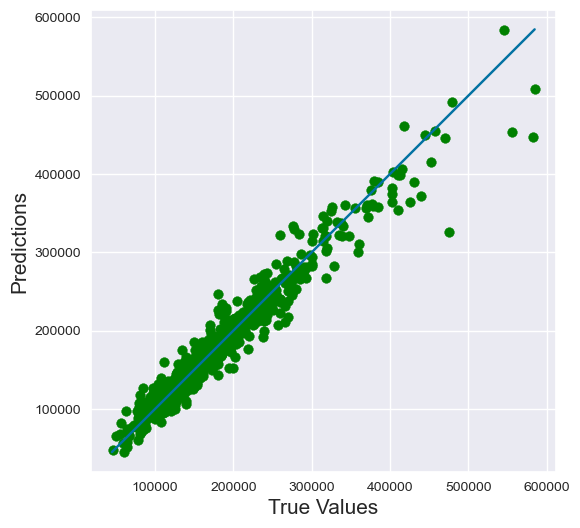

In [225]:
true_value = np.exp(y_test)
plt.figure(figsize=(6,6))


plt.scatter(true_value, predictions0, c='green')
#plt.yscale('log')
#plt.xscale('log')


p1 = max(max(predictions0), max(true_value))
p2 = min(min(predictions0), min(true_value))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

# CatBoostV2

In [226]:
result = {}
model = models["catboostV2"]
kf = KFold(n_splits=10)

result_train2 = np.exp(np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=kf)))
np.mean(result_train2)

1.132576892912304

In [227]:
result_test2 = np.exp(np.sqrt(-cross_val_score(model, X_test, y_test, scoring="neg_mean_squared_error", cv=kf)))
np.mean(result_test2)

1.1231966565732692

In [233]:
predictions2 = (np.exp(models["catboostV2"].predict(X_test)))
true_value = np.exp(y_test)

In [234]:
# y_true: actual values of the target variable
# y_pred: predicted values of the target variable
r2 = r2_score(true_value, predictions2)
print('R-squared: ', r2)

R-squared:  0.9468867960014081


In [235]:
# y_true: actual values of the target variable
# y_pred: predicted values of the target variable
mse = mean_squared_error(true_value, predictions2)
me = np.log(np.sqrt(mse))
print('Mean squared error:', me)

Mean squared error: 9.830884094912685


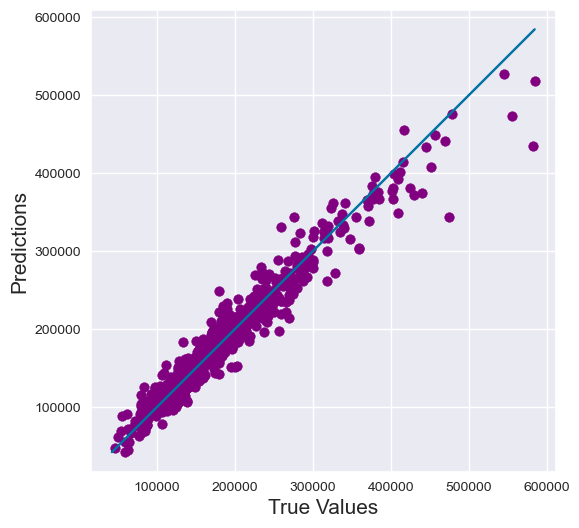

In [237]:

plt.figure(figsize=(6,6))


plt.scatter(true_value, predictions2, c='purple')
#plt.yscale('log')
#plt.xscale('log')


p1 = max(max(predictions2), max(true_value))
p2 = min(min(predictions2), min(true_value))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

# BayesianRidge

In [238]:
result = {}
model = models["br"]
kf = KFold(n_splits=10)

result_train3 = np.exp(np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=kf)))
np.mean(result_train3)

1.1490779538976559

In [239]:
result_test3 = np.exp(np.sqrt(-cross_val_score(model, X_test, y_test, scoring="neg_mean_squared_error", cv=kf)))
np.mean(result_test3)

1.1195655903299555

In [240]:
predictions3 = (np.exp(models["br"].predict(X_test)))
true_value = np.exp(y_test)

In [241]:
# y_true: actual values of the target variable
# y_pred: predicted values of the target variable
r2 = r2_score(true_value, predictions3)
print('R-squared: ', r2)

R-squared:  0.9446538534470024


In [253]:
# y_true: actual values of the target variable
# y_pred: predicted values of the target variable
mse = mean_squared_error(true_value, predictions3)
me = np.log(np.sqrt(mse))
print('Mean squared error:', me)

Mean squared error: 9.851474833353839


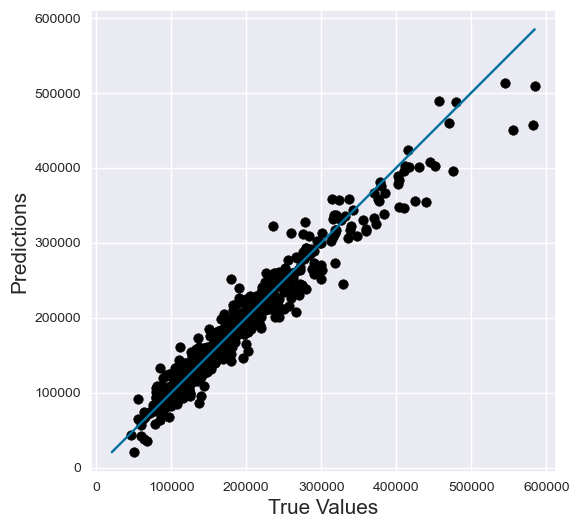

In [248]:

plt.figure(figsize=(6,6))


plt.scatter(true_value, predictions3, c='black')
#plt.yscale('log')
#plt.xscale('log')


p1 = max(max(predictions3), max(true_value))
p2 = min(min(predictions3), min(true_value))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

# BayesianRidgeV2

In [249]:
result = {}
model = models["brV2"]
kf = KFold(n_splits=10)

result_train4 = np.exp(np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=kf)))
np.mean(result_train4)

1.1463704775427124

In [255]:
result_test4 = np.exp(np.sqrt(-cross_val_score(model, X_test, y_test, scoring="neg_mean_squared_error", cv=kf)))
np.mean(result_test4)

1.1211537546787806

In [258]:
predictions4 = (np.exp(models["brV2"].predict(X_test)))
true_value = np.exp(y_test)

In [257]:
4# y_true: actual values of the target variable
# y_pred: predicted values of the target variable
r2 = r2_score(true_value, predictions4)
print('R-squared: ', r2)

R-squared:  0.9425917083688583


In [259]:
# y_true: actual values of the target variable
# y_pred: predicted values of the target variable
mse = mean_squared_error(true_value, predictions4)
me = np.log(np.sqrt(mse))
print('Mean squared error:', me)

Mean squared error: 9.869765688006312


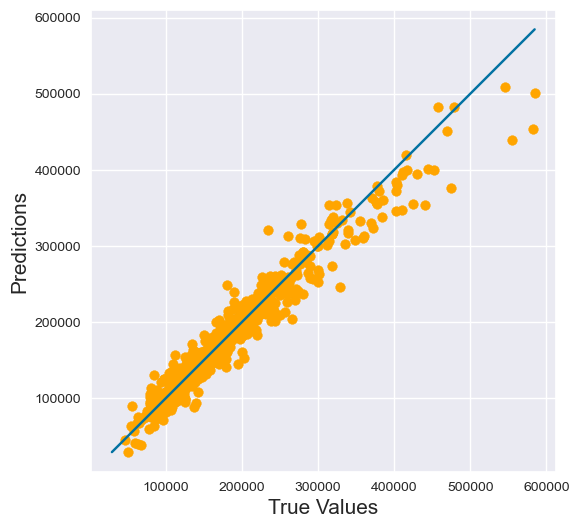

In [261]:

plt.figure(figsize=(6,6))


plt.scatter(true_value, predictions4, c='orange')
#plt.yscale('log')
#plt.xscale('log')


p1 = max(max(predictions4), max(true_value))
p2 = min(min(predictions4), min(true_value))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

# LightGBM

In [265]:
result = {}
model = models["lightgbm"]
kf = KFold(n_splits=10)

result_train3 = np.exp(np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=kf)))
np.mean(result_train3)

1.1460150747121987

In [266]:
result_test3 = np.exp(np.sqrt(-cross_val_score(model, X_test, y_test, scoring="neg_mean_squared_error", cv=kf)))
np.mean(result_test3)

1.139124485234155

In [267]:
predictions3 = (np.exp(models["lightgbm"].predict(X_test)))
true_value = np.exp(y_test)

In [268]:
# y_true: actual values of the target variable
# y_pred: predicted values of the target variable
r2 = r2_score(true_value, predictions3)
print('R-squared: ', r2)

R-squared:  0.9339882116970848


In [269]:
# y_true: actual values of the target variable
# y_pred: predicted values of the target variable
mse = mean_squared_error(true_value, predictions3)
me = np.log(np.sqrt(mse))
print('Mean squared error:', me)

Mean squared error: 9.939587983171485


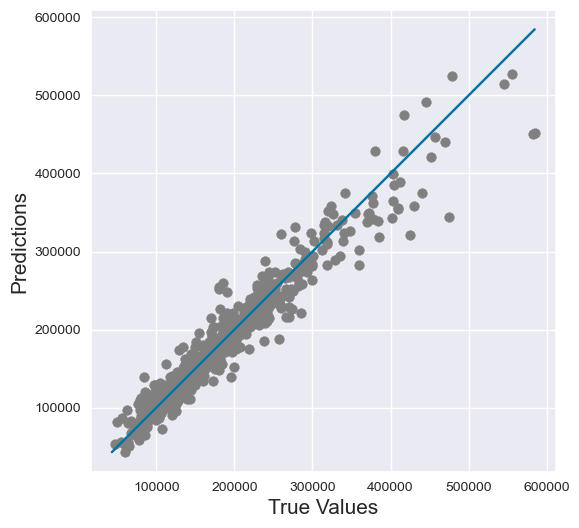

In [270]:

plt.figure(figsize=(6,6))


plt.scatter(true_value, predictions3, c='grey')
#plt.yscale('log')
#plt.xscale('log')


p1 = max(max(predictions3), max(true_value))
p2 = min(min(predictions3), min(true_value))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

# LightGBMV2

In [271]:
result = {}
model = models["lightgbmV2"]
kf = KFold(n_splits=10)

result_train3 = np.exp(np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=kf)))
np.mean(result_train3)

1.1466910665151915

In [272]:
result_test3 = np.exp(np.sqrt(-cross_val_score(model, X_test, y_test, scoring="neg_mean_squared_error", cv=kf)))
np.mean(result_test3)

1.1301502925910105

In [273]:
predictions3 = (np.exp(models["lightgbmV2"].predict(X_test)))
true_value = np.exp(y_test)

In [274]:
# y_true: actual values of the target variable
# y_pred: predicted values of the target variable
r2 = r2_score(true_value, predictions3)
print('R-squared: ', r2)

R-squared:  0.9450756583224573


In [275]:
# y_true: actual values of the target variable
# y_pred: predicted values of the target variable
mse = mean_squared_error(true_value, predictions3)
me = np.log(np.sqrt(mse))
print('Mean squared error:', me)

Mean squared error: 9.847649630985291


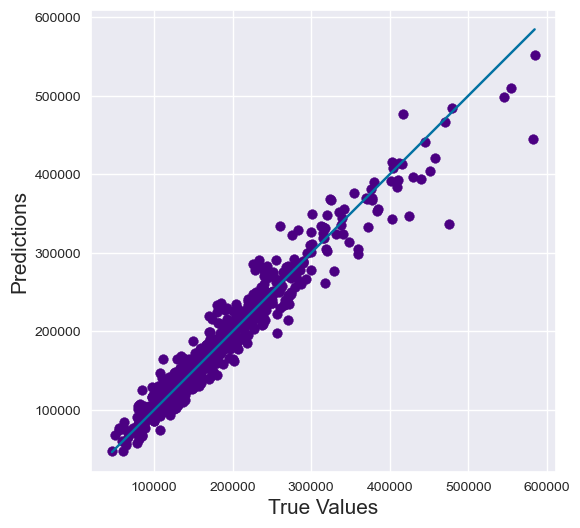

In [276]:

plt.figure(figsize=(6,6))


plt.scatter(true_value, predictions3, c='indigo')
#plt.yscale('log')
#plt.xscale('log')


p1 = max(max(predictions3), max(true_value))
p2 = min(min(predictions3), min(true_value))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

# Ridge

In [277]:
result = {}
model = models["ridge"]
kf = KFold(n_splits=10)

result_train3 = np.exp(np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=kf)))
np.mean(result_train3)

1.1560760196274147

In [278]:
result_test3 = np.exp(np.sqrt(-cross_val_score(model, X_test, y_test, scoring="neg_mean_squared_error", cv=kf)))
np.mean(result_test3)

1.1387914821337781

In [240]:
predictions3 = (np.exp(models["ridge"].predict(X_test)))
true_value = np.exp(y_test)

In [241]:
# y_true: actual values of the target variable
# y_pred: predicted values of the target variable
r2 = r2_score(true_value, predictions3)
print('R-squared: ', r2)

R-squared:  0.9446538534470024


In [253]:
# y_true: actual values of the target variable
# y_pred: predicted values of the target variable
mse = mean_squared_error(true_value, predictions3)
me = np.log(np.sqrt(mse))
print('Mean squared error:', me)

Mean squared error: 9.851474833353839


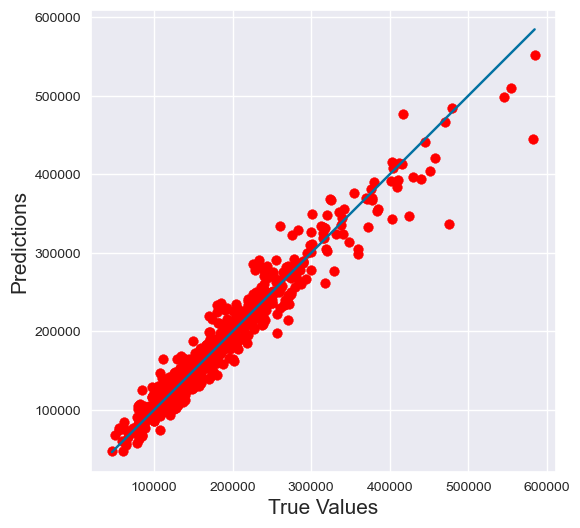

In [280]:

plt.figure(figsize=(6,6))


plt.scatter(true_value, predictions3, c='red')
#plt.yscale('log')
#plt.xscale('log')


p1 = max(max(predictions3), max(true_value))
p2 = min(min(predictions3), min(true_value))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

# RidgeV2

In [281]:
result = {}
model = models["ridgeV2"]
kf = KFold(n_splits=10)

result_train3 = np.exp(np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=kf)))
np.mean(result_train3)

1.14435902386924

In [282]:
result_test3 = np.exp(np.sqrt(-cross_val_score(model, X_test, y_test, scoring="neg_mean_squared_error", cv=kf)))
np.mean(result_test3)

1.1234005788627153

In [283]:
predictions3 = (np.exp(models["ridgeV2"].predict(X_test)))
true_value = np.exp(y_test)

In [284]:
# y_true: actual values of the target variable
# y_pred: predicted values of the target variable
r2 = r2_score(true_value, predictions3)
print('R-squared: ', r2)

R-squared:  0.9358448312713726


In [285]:
# y_true: actual values of the target variable
# y_pred: predicted values of the target variable
mse = mean_squared_error(true_value, predictions3)
me = np.log(np.sqrt(mse))
print('Mean squared error:', me)

Mean squared error: 9.925323644987028


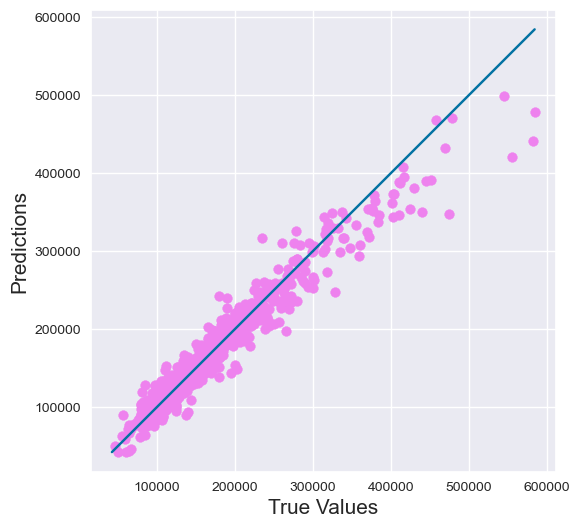

In [287]:

plt.figure(figsize=(6,6))


plt.scatter(true_value, predictions3, c='violet')
#plt.yscale('log')
#plt.xscale('log')


p1 = max(max(predictions3), max(true_value))
p2 = min(min(predictions3), min(true_value))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

# Orthogonal

In [289]:
result = {}
model = models["omp"]
kf = KFold(n_splits=10)

result_train3 = np.exp(np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=kf)))
np.mean(result_train3)

1.160903875855509

In [290]:
result_test3 = np.exp(np.sqrt(-cross_val_score(model, X_test, y_test, scoring="neg_mean_squared_error", cv=kf)))
np.mean(result_test3)

1.124186947271952

In [291]:
predictions3 = (np.exp(models["omp"].predict(X_test)))
true_value = np.exp(y_test)

In [292]:
# y_true: actual values of the target variable
# y_pred: predicted values of the target variable
r2 = r2_score(true_value, predictions3)
print('R-squared: ', r2)

R-squared:  0.9327812156298894


In [293]:
# y_true: actual values of the target variable
# y_pred: predicted values of the target variable
mse = mean_squared_error(true_value, predictions3)
me = np.log(np.sqrt(mse))
print('Mean squared error:', me)

Mean squared error: 9.94864768370024


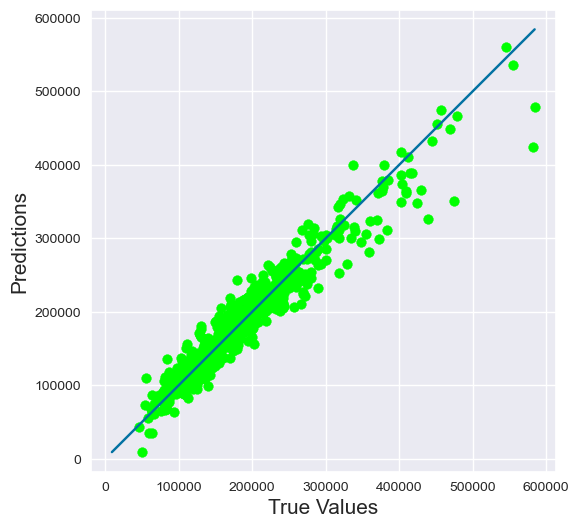

In [295]:

plt.figure(figsize=(6,6))


plt.scatter(true_value, predictions3, c='lime')
#plt.yscale('log')
#plt.xscale('log')


p1 = max(max(predictions3), max(true_value))
p2 = min(min(predictions3), min(true_value))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [297]:
results = {}

kf = KFold(n_splits=10)

for name, model in models.items():
    result = np.exp(np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=kf)))
    results[name] = np.mean(result)

In [298]:
results

{'catboost': 1.1331649319389523,
 'catboostV2': 1.132576892912304,
 'br': 1.1490779538976559,
 'brV2': 1.1463704775427124,
 'lightgbm': 1.1460150747121987,
 'lightgbmV2': 1.1466910665151915,
 'ridge': 1.1560760196274147,
 'ridgeV2': 1.14435902386924,
 'omp': 1.160903875855509}

# Predictons

In [328]:
predictions_final = (
    0.2 * np.exp(models["catboost"].predict(X_test)) +
    0.2 * np.exp(models["br"].predict(X_test)) +
    0.2 * np.exp(models["lightgbm"].predict(X_test)) +
    0.2 * np.exp(models["ridge"].predict(X_test)) +
    0.2 * np.exp(models["omp"].predict(X_test)) 
)


In [329]:
predictions_final = pd.Series(predictions_final, name="Predicted_Sale_Price")
predictions_final.index = y_test.index
predictions_final = pd.concat([predictions_final , np.exp(y_test)], axis=1)
predictions_final

,Predicted_Sale_Price,Sale_Price
2465,199094.872351,200825.0
714,112027.374068,110000.0
2905,157455.482689,164000.0
2043,37428.153623,50000.0
672,149911.166402,153000.0
...,...,...
662,55377.124732,59000.0
1141,208718.945346,193500.0
2057,128991.154613,119900.0
120,149834.209557,159000.0


In [330]:
predictions = predictions_final["Predicted_Sale_Price"]
true_value = np.exp(y_test)

In [332]:
# y_true: actual values of the target variable
# y_pred: predicted values of the target variable
r2 = r2_score(true_value, predictions)
print('R-squared: ', r2)

R-squared:  0.9514838216354762


In [334]:
# y_true: actual values of the target variable
# y_pred: predicted values of the target variable
mse = mean_squared_error(true_value, predictions)
me = np.log(np.sqrt(mse))
print('Mean squared error:', me)

Mean squared error: 9.785619973230693


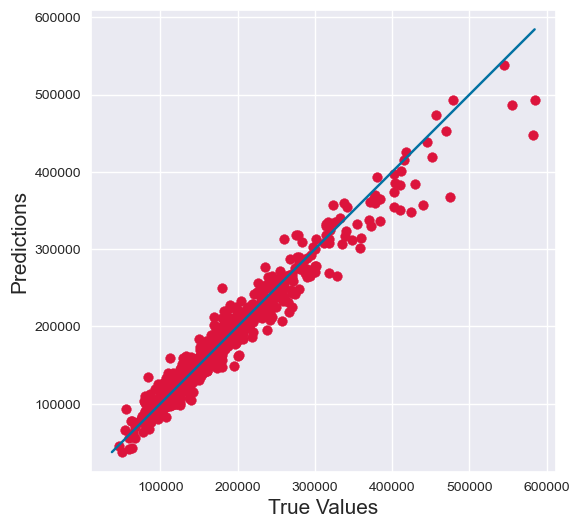

In [315]:
predicted_value = predictions_final['Predicted_Sale_Price']
true_value = predictions_final['Sale_Price']
plt.figure(figsize=(6,6))


plt.scatter(true_value, predicted_value, c='crimson')
#plt.yscale('log')
#plt.xscale('log')


p1 = max(max(predicted_value), max(true_value))
p2 = min(min(predicted_value), min(true_value))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [318]:
y_pred = predictions1.astype(int)
acc = accuracy_score(true_value.astype(int), predicted_value.astype(int))
acc

0.0

# Final Version

In [323]:
predictions_finalV2 = (
    0.4 * np.exp(models["catboostV2"].predict(X_test)) +
    0.2 * np.exp(models["brV2"].predict(X_test)) +
    0.2 * np.exp(models["lightgbmV2"].predict(X_test)) +
    0.2 * np.exp(models["ridgeV2"].predict(X_test)) 
)


In [324]:
predictions_finalV2 = pd.Series(predictions_finalV2, name="Predicted_Sale_Price")
predictions_finalV2.index = y_test.index
predictions_finalV2 = pd.concat([predictions_finalV2 , np.exp(y_test)], axis=1)
predictions_finalV2

,Predicted_Sale_Price,Sale_Price
2465,199422.850095,200825.0
714,109797.100541,110000.0
2905,161684.851116,164000.0
2043,52718.918563,50000.0
672,150000.820229,153000.0
...,...,...
662,57671.759959,59000.0
1141,212629.610985,193500.0
2057,129205.847754,119900.0
120,147135.355356,159000.0


In [335]:
predictions = predictions_finalV2["Predicted_Sale_Price"]
true_value = np.exp(y_test)

In [336]:
# y_true: actual values of the target variable
# y_pred: predicted values of the target variable
r2 = r2_score(true_value, predictions)
print('R-squared: ', r2)

R-squared:  0.9495864583324096


In [337]:
# y_true: actual values of the target variable
# y_pred: predicted values of the target variable
mse = mean_squared_error(true_value, predictions)
me = np.log(np.sqrt(mse))
print('Mean squared error:', me)

Mean squared error: 9.804801226242166


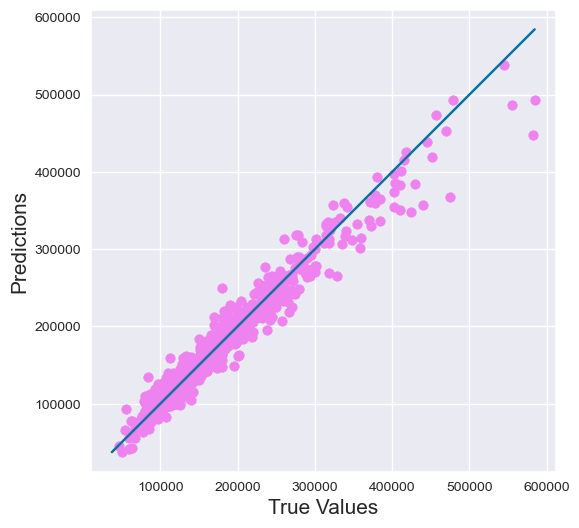

In [325]:
predicted_value = predictions_final['Predicted_Sale_Price']
true_value = predictions_final['Sale_Price']
plt.figure(figsize=(6,6))


plt.scatter(true_value, predicted_value, c='violet')
#plt.yscale('log')
#plt.xscale('log')


p1 = max(max(predicted_value), max(true_value))
p2 = min(min(predicted_value), min(true_value))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [338]:
y_pred = predictions1.astype(int)
acc = accuracy_score(true_value.astype(int), predicted_value.astype(int))
acc

0.0